In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [6]:
# Upload the data
series = pd.read_csv('monthly-car-sales-in-quebec-1960.csv')['Count']
print(series)

0       6550
1       8728
2      12026
3      14395
4      14587
       ...  
103    16722
104    14385
105    21342
106    17180
107    14577
Name: Count, Length: 108, dtype: int64


Results of Dickey-Fuller Test:
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


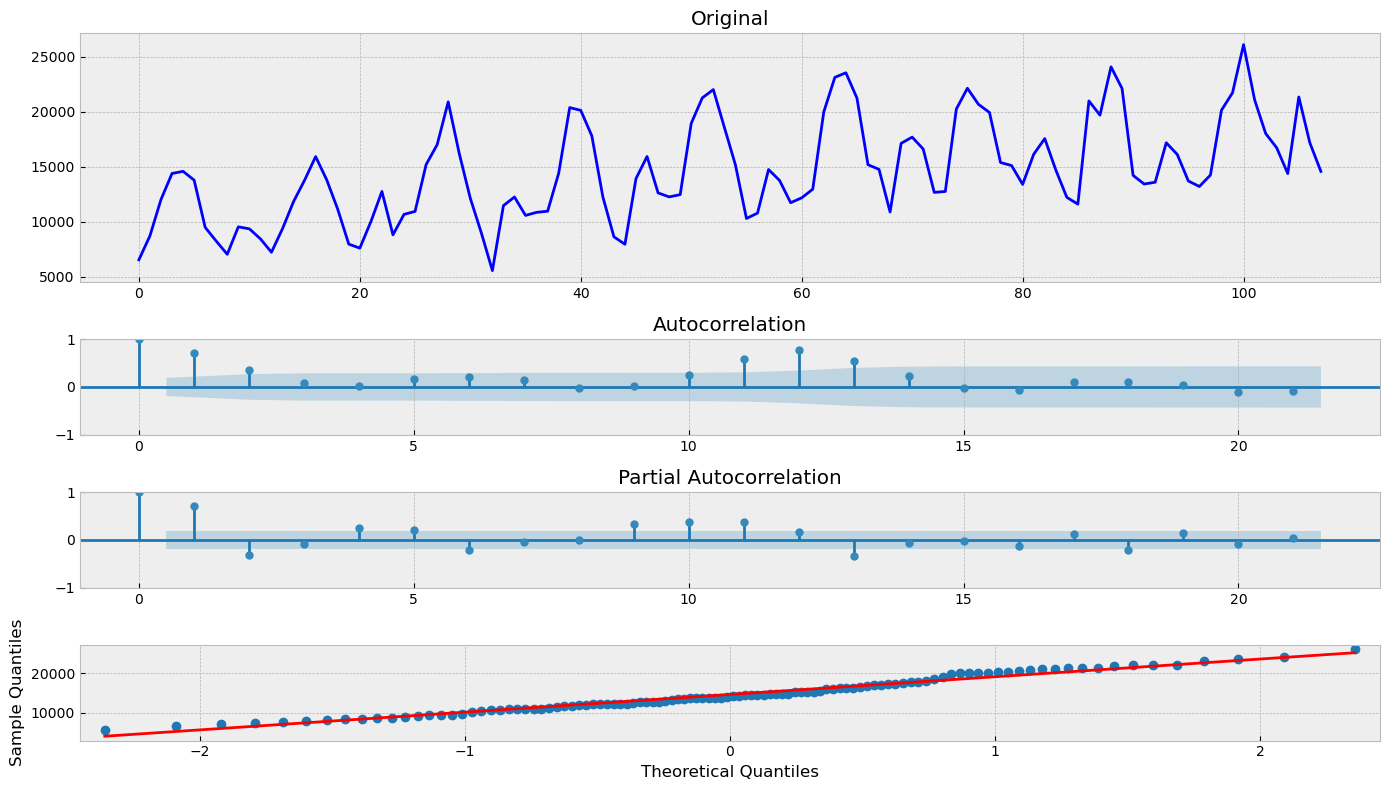

In [7]:
tsplot(series)

In [8]:
# Find the best parameters for the ARIMA model
from pmdarima import auto_arima

best_param = auto_arima(series, trace=True, suppress_warnings=True)
best_param.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2006.439, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2042.237, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2041.299, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2041.105, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2040.297, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2003.066, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2016.379, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2006.696, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2007.889, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2014.649, Time=0.11 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2001.135, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -994.567
Date:                Wed, 06 Mar 2024   AIC                           2001.135
Time:                        15:34:26   BIC                           2017.172
Sample:                             0   HQIC                          2007.636
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7167      0.148      4.826      0.000       0.426       1.008
ar.L2         -0.7288      0.148     -4.920      0.000      -1.019      -0.438
ar.L3         -0.2336      0.144     -1.623      0.104      -0.516       0.048
ma.L1         -0.7505      0.062    -12.055      0.000      -0.872      -0.628
ma.L2          0.9108      0.086     10.533      0.000       0.741       1.080
sigma2      8.572e+06   2.81e-09   3.05e+15      0.000    8.57e+06    8.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.90   Prob(JB):                         0.81
Heteroskedasticity (H):               1.52   Skew:                             0.15
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.09e+31. Standard errors may be unstable.
"""

In [9]:
# Build the GARCH model using ARIMA parameters
from arch import arch_model
from scipy.stats import boxcox

series = boxcox(series, 0)
series = np.diff(series, 1)

In [10]:
p_, o_, q_ = best_param.order
am = arch_model(series*100, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     55,   Neg. LLF: 490.1876116724461
Iteration:     10,   Func. Count:    106,   Neg. LLF: 489.67654972608455
Iteration:     15,   Func. Count:    156,   Neg. LLF: 489.13593166817844
Iteration:     20,   Func. Count:    206,   Neg. LLF: 489.0160890283957
Optimization terminated successfully    (Exit mode 0)
            Current function value: 489.01003885029337
            Iterations: 24
            Function evaluations: 259
            Gradient evaluations: 24
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -489.010
Distribution:      Standardized Student's t   AIC:                           996.020
Method:                  Maximum Likelihood   BIC:                        

Results of Dickey-Fuller Test:
Test Statistic                 -4.193835
p-value                         0.000675
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


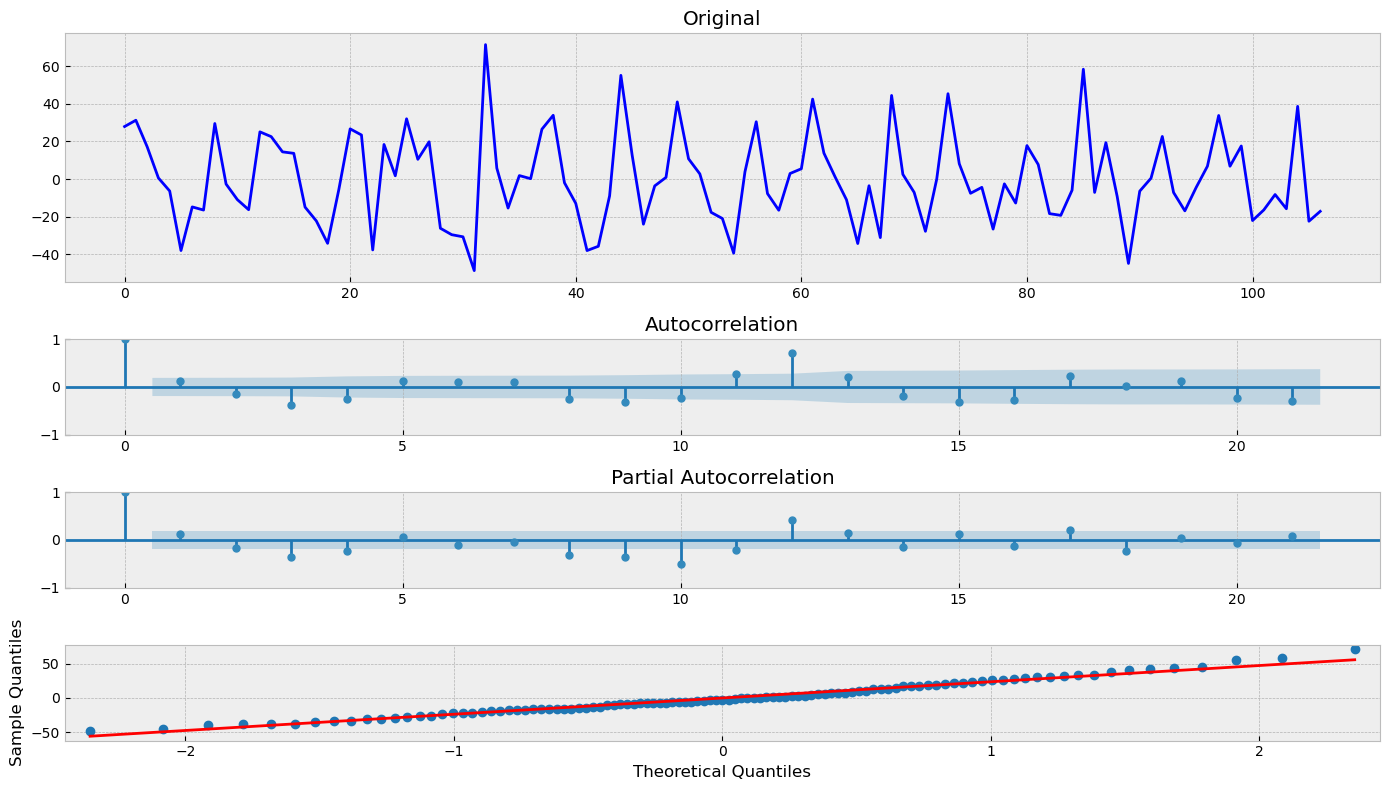

In [11]:
tsplot(res.resid)

In [12]:
forecast = res.forecast(horizon=100)

In [13]:
forecast.residual_variance.iloc[-1]

h.001    556.731072
h.002    593.890024
h.003    579.739214
h.004    586.303050
h.005    584.087182
            ...    
h.096    585.378871
h.097    585.378871
h.098    585.378871
h.099    585.378871
h.100    585.378871
Name: 106, Length: 100, dtype: float64